# Inhibitory-stabilized rate sequence network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_plot

N = 128
RTH = np.linspace(0, 2*np.pi, N)
DTH = np.mean(np.diff(RTH))

def get_cmn_p(p):
    """
    Circular mean from prob distr.
    
    p: corresponding probabilities
    """
    return np.arctan2(p@np.sin(RTH), p@np.cos(RTH))

def make_J(N, g):
    J = np.diag(np.ones(N-1), -1)
    J[0, -1] = 1
    J *= g
    return J

def get_c_spd(c_mn, t, t_start):
    """Estimate speed of uniform circular motion.
    c_mn in radians
    """
    c_mn_unw = np.unwrap(c_mn)
    
    slp = stats.linregress(t[t_start <= t], c_mn_unw[t_start <= t])[0]
    
    return slp

def get_bump_spread(rs, r_0):
    return DTH*np.sum(rs >= r_0)/len(rs)

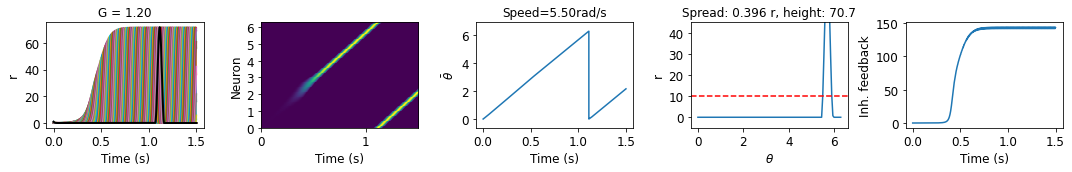

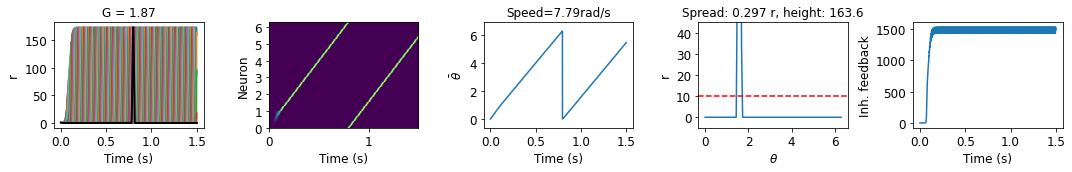

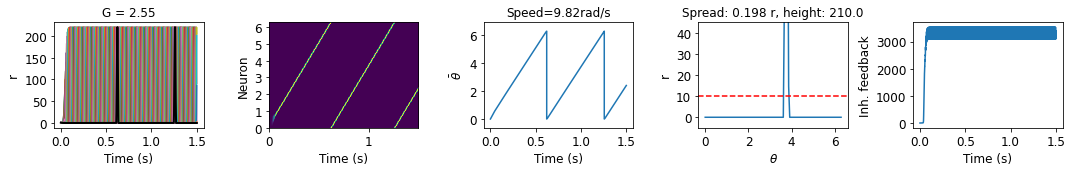

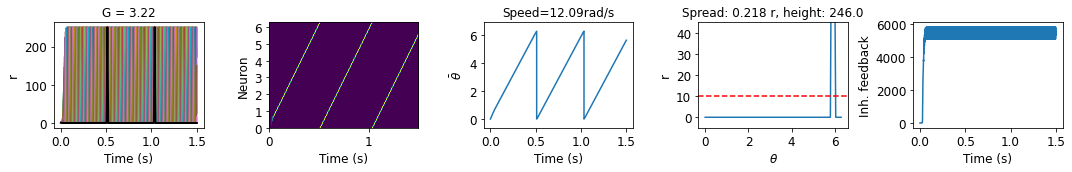

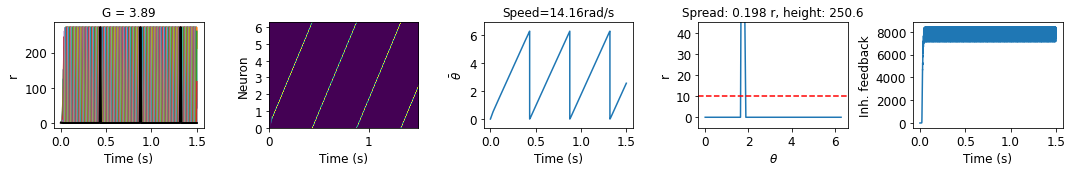

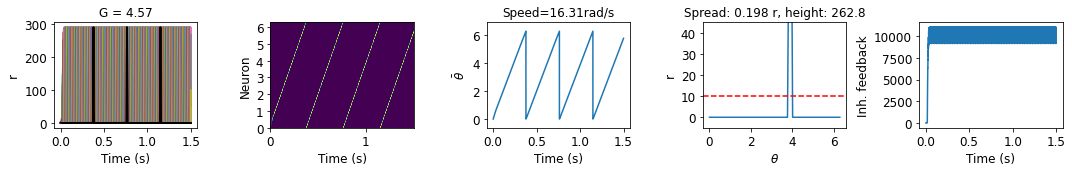

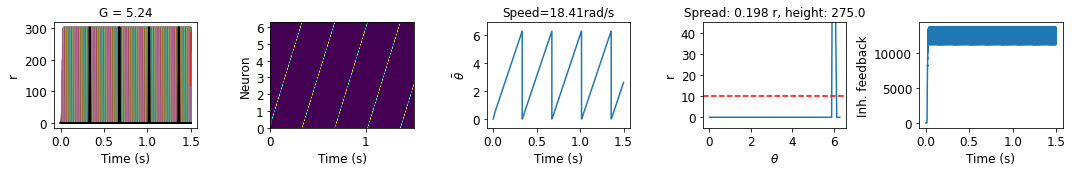

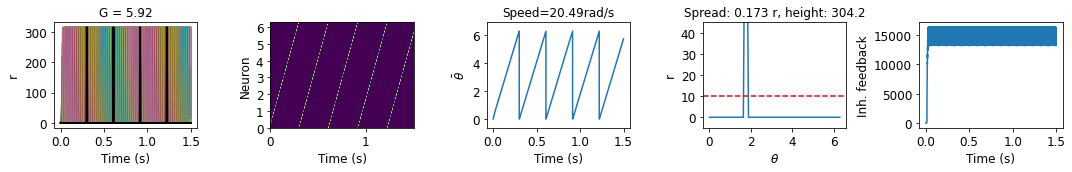

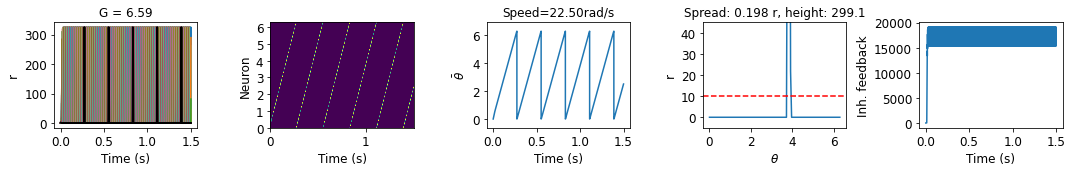

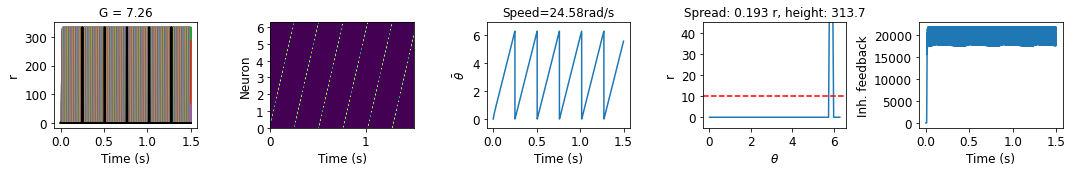

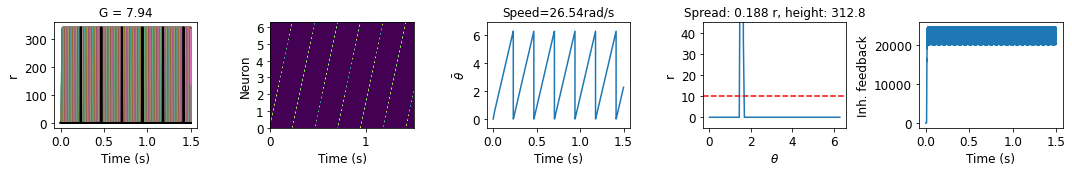

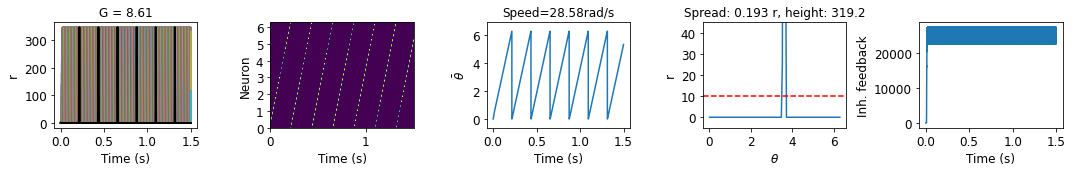

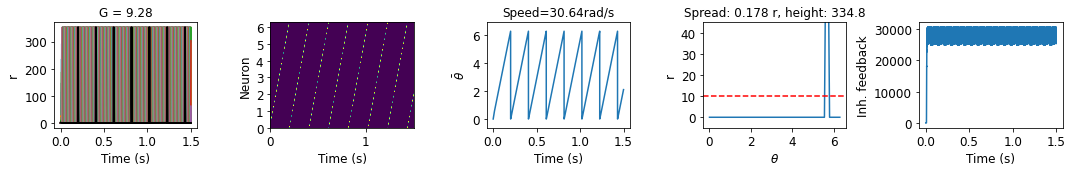

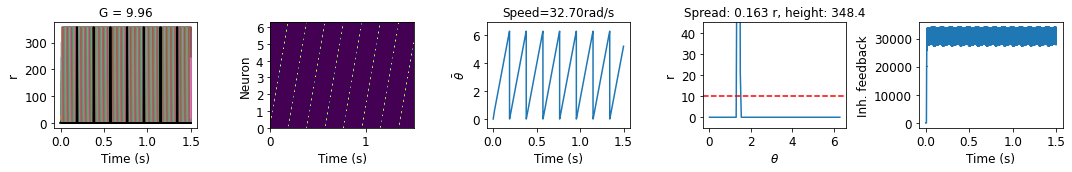

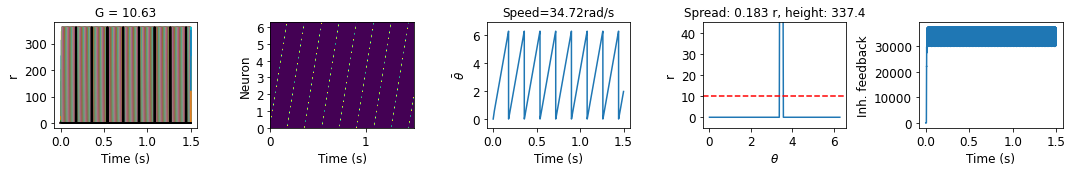

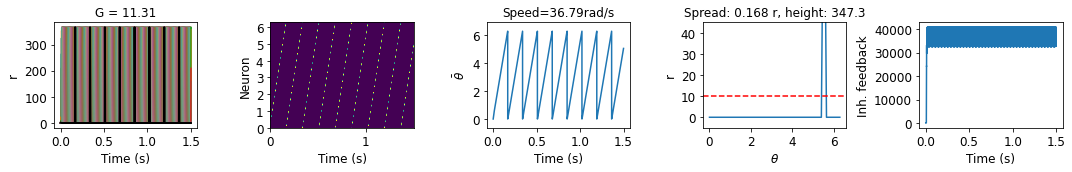

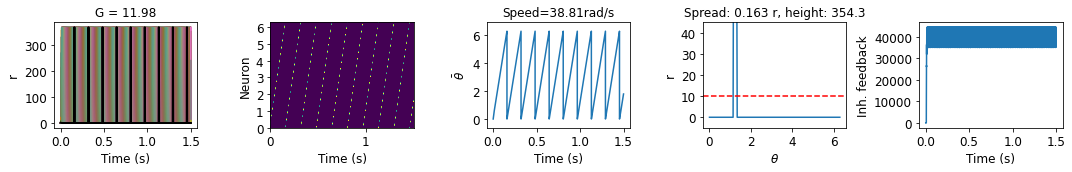

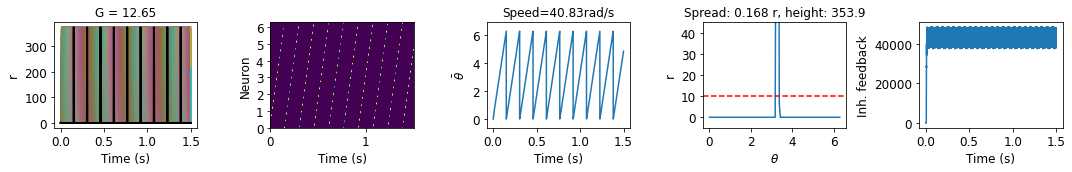

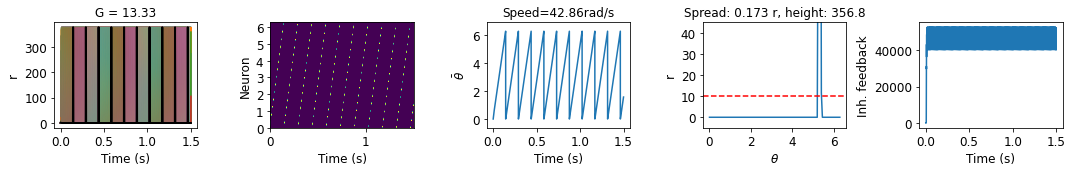

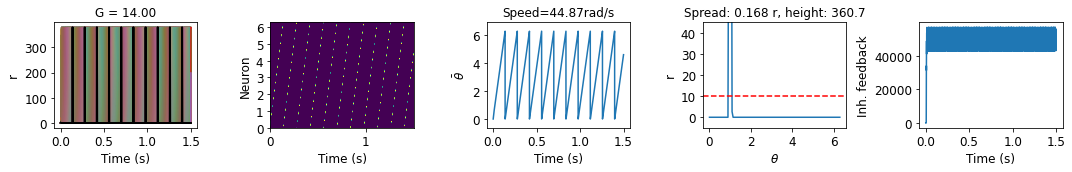

In [2]:
gs = np.linspace(1.2, 14, 20)

DT = .0001
t = np.arange(0, 1.5, DT)

TAU = .01
J_Z = -0.05*np.ones((N, 1))

M_0 = .5
BETA = 2
# BETA = 1
phi_z = lambda r: np.exp(BETA*(np.mean(r) - M_0))

c_spds = []
spreads = []
heights = []

for g in gs:
    J = make_J(N, g)

    rs = np.nan*np.zeros((len(t), N))
    rs[0, :] = np.eye(N)[0, :]

    zs = np.nan*np.zeros((len(t), 1))
    zs[0, :] = phi_z(rs[0, :])

    for ct, t_ in enumerate(t[1:], 1):
        dr = (DT/TAU)*(-rs[ct-1, :] + J@rs[ct-1, :] + J_Z@zs[ct-1, :])
        r = rs[ct-1, :] + dr
        rs[ct, :] = np.where(r > 0, r, 0)

        z = phi_z(rs[ct, :])
        zs[ct, :] = [z]

    ps = np.array([r/np.sum(r) for r in rs])
    c_mns = np.array([get_cmn_p(p) for p in ps])
    
    c_spd = get_c_spd(c_mns, t, t_start=1.0)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 2.5), tight_layout=True)
    
    axs[0].plot(t, rs)
    axs[0].plot(t, rs[:, 0], c='k', lw=2)
    set_plot(axs[0], x_label='Time (s)', y_label='r', title=f'G = {g:.2f}')
    
    axs[1].matshow(rs.T, origin='lower', extent=[t[0], t[-1], RTH[0], RTH[-1]])
    axs[1].set_aspect('auto')
    axs[1].xaxis.tick_bottom()
    set_plot(axs[1], x_label='Time (s)', y_label='Neuron')
    
    axs[2].plot(t, c_mns%(2*np.pi))
    set_plot(axs[2], y_lim=(-.1*2*np.pi, 1.1*2*np.pi), x_label='Time (s)', y_label=r'$\bar{\theta}$', title=f'Speed={c_spd:.2f}rad/s')
    
    spread = get_bump_spread(rs[-10:, :], r_0=10)
    height = np.max(rs[-10:, :], axis=1).mean()
    t_snap = 1.
    it_snap = int(round(t_snap/DT))
    axs[3].plot(RTH, rs[it_snap, :])
    axs[3].axhline(10, c='r', ls='--')
    set_plot(axs[3], y_lim=(-5, 45), x_label=r'$\theta$', y_label='r', title=f'Spread: {spread:.3f} r, height: {height:.1f}')
                
    axs[4].plot(t, zs[:, 0])
    set_plot(axs[4], x_label='Time (s)', y_label='Inh. feedback')
    
    c_spds.append(c_spd)
    spreads.append(spread)
    heights.append(height)

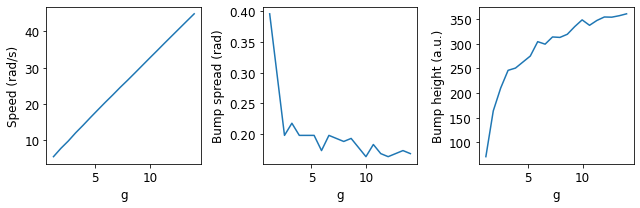

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
axs[0].plot(gs, c_spds)
set_plot(axs[0], x_label='g', y_label='Speed (rad/s)')

axs[1].plot(gs, spreads)
set_plot(axs[1], x_label='g', y_label='Bump spread (rad)')

axs[2].plot(gs, heights)
set_plot(axs[2], x_label='g', y_label='Bump height (a.u.)')